In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import rasterio as rs
import hickle as hkl
from scipy.ndimage import median_filter, maximum_filter, percentile_filter
import yaml
import boto3
import zipfile
import os
import copy
import time
from skimage.transform import resize
from scipy.ndimage.morphology import binary_dilation, binary_erosion

%run ../../src/change/change.py

In [18]:
x = 445
y = 1159
VERBOSE = False

In [19]:
with open("../../config.yaml", 'r') as stream:
    key = (yaml.safe_load(stream))
    API_KEY = key['key']
    SHUB_SECRET = key['shub_secret']
    SHUB_KEY = key['shub_id']
    AWSKEY = key['awskey']
    AWSSECRET = key['awssecret']

data = pd.read_csv("../../src/process_area_2022.csv")
data = data[data['country'] == 'Costa Rica']
try:
    data['X_tile'] = data['X_tile'].str.extract('(\d+)', expand=False)
    data['X_tile'] = pd.to_numeric(data['X_tile'])
    data['Y_tile'] = data['Y_tile'].str.extract('(\d+)', expand=False)
    data['Y_tile'] = pd.to_numeric(data['Y_tile'])
except Exception as e:
    print(f"Ran into {str(e)} error")
    time.sleep(1)

Ran into Can only use .str accessor with string values! error


In [20]:
def load_ttc_tiles(x, y):
    f20_path = f'/Volumes/Johns Drive2/tof-output/{str(x)}/{str(y)}/{str(x)}X{str(y)}Y_FINAL.tif'


    f17 = rs.open(f'/Volumes/Johns Drive2/tof-output-2017/{str(x)}/{str(y)}/{str(x)}X{str(y)}Y_FINAL.tif').read(1).astype(np.float32)[np.newaxis]
    f18 = rs.open(f'/Volumes/Johns Drive2/tof-output-2018/{str(x)}/{str(y)}/{str(x)}X{str(y)}Y_FINAL.tif').read(1).astype(np.float32)[np.newaxis]
    f19 = rs.open(f'/Volumes/Johns Drive2/tof-output-2019/{str(x)}/{str(y)}/{str(x)}X{str(y)}Y_FINAL.tif').read(1).astype(np.float32)[np.newaxis]
    if os.path.exists(f20_path):
        f20 = rs.open(f20_path).read(1).astype(np.float32)[np.newaxis]
    f21 = rs.open(f'/Volumes/Johns Drive2/tof-output-2021/{str(x)}/{str(y)}/{str(x)}X{str(y)}Y_FINAL.tif').read(1).astype(np.float32)[np.newaxis]
    if not os.path.exists(f20_path):
        f20 = np.mean(np.concatenate([f19, f21], axis = 0), axis = 0)[np.newaxis]
    
    f22 = rs.open(f'/Volumes/Johns Drive2/tof-output-2022/{str(x)}/{str(y)}/{str(x)}X{str(y)}Y_FINAL.tif').read(1).astype(np.float32)[np.newaxis]
    fs = np.concatenate([f17, f18, f19, f20, f21, f22], axis = 0) # , f22
    fs = np.float32(fs)
    fs = 100 * (fs - 15) / 85
    fs[fs < 0] = 0.
    fs[fs < 20] = 0.
    
    for i in range(0, fs.shape[0]):
        if i == 0:
            isnan = np.logical_or(np.isnan(fs[i]), fs[i] >= 255)
            fs[i, isnan] = fs[i + 1, isnan]
        if i == (fs.shape[0] - 1):
            isnan = np.logical_or(np.isnan(fs[i]), fs[i] >= 255)
            fs[i, isnan] = fs[i - 1, isnan]
        else:
            isnan = np.logical_or(np.isnan(fs[i]), fs[i] >= 255)
            isnannext = np.logical_or(np.isnan(fs[i + 1]), fs[i + 1] >= 255)
            isnanbefore = np.logical_or(np.isnan(fs[i - 1]), fs[i - 1] >= 255)
            isnan = isnan * isnannext * isnanbefore
            fs[i, isnan] = (fs[i - 1, isnan] + fs[i + 1, isnan]) / 2
    
    stable = np.sum(fs > 30, axis = 0) == 6
    stable = binary_erosion(stable)
    notree = np.sum(fs < 50, axis = 0) == 6
    notree = binary_erosion(notree)

    fs = temporal_filter(fs)
    changemap = None
    return fs, changemap, stable, notree

In [21]:
xs = [445]
ys = [1159]

In [22]:
data = data.reindex(index=data.index[::-1])
data = data.sample(frac=1).reset_index(drop=True)
#data = data[data.X_tile == xs[0]]
#data = data[data.Y_tile == ys[0]]
data.head(5)

,X,Y,Y_tile,X_tile,country
0,-85.4167,10.3611,1150,443,Costa Rica
1,-83.7500,8.5833,1118,473,Costa Rica
2,-85.1944,9.6389,1137,447,Costa Rica
3,-84.2500,10.2500,1148,464,Costa Rica
4,-84.3056,10.3611,1150,463,Costa Rica


In [137]:

def remove_unstable_loss(year, med, fs):
    ttc_year = fs[year - 2017]
    loss_year = med == (year - 1817)
    if year < 2022:
        next_year = fs[year - 2018]
        unstable_loss = (next_year > 60) * (ttc_year < 30) * loss_year
    else:
        unstable_loss = np.zeros_like(fs[0])
    return unstable_loss



STARTING 445, 1159
(1, 618, 606) (1, 618, 606)
Starting download of s3://tof-output/2017/change/445/1159/445X1159Y_ard.zip to output.zip from tof-output
Starting download of s3://tof-output/2018/change/445/1159/445X1159Y_ard.zip to output.zip from tof-output
Starting download of s3://tof-output/2019/change/445/1159/445X1159Y_ard.zip to output.zip from tof-output
Starting download of s3://tof-output/2020/change/445/1159/445X1159Y_ard.zip to output.zip from tof-output
Starting download of s3://tof-output/2021/change/445/1159/445X1159Y_ard.zip to output.zip from tof-output
Starting download of s3://tof-output/2022/change/445/1159/445X1159Y_ard.zip to output.zip from tof-output
(1, 618, 606) (1, 618, 606)
[4, 7, 5, 3, 5, 8]
2018 0
2019 1
2020 2
2021 3
2022 4
Reference: 0.4
No addtl gain 337822
0 No Large Gain detected: []: False, 338185
6 Large Gain detected: 16 events: False, 4.0, 0 Slope: 6.03303337097168, 16 px
8 Large Gain detected: 14 events: False, 4.0, 10 Slope: 2.862405300140381, 1

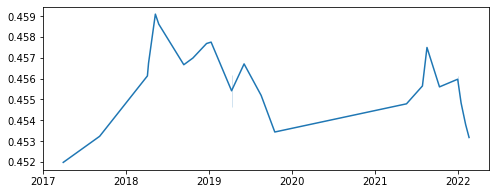

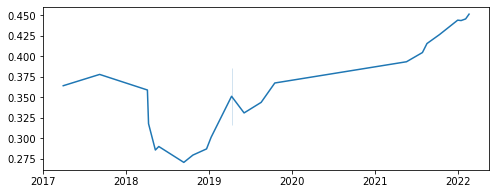

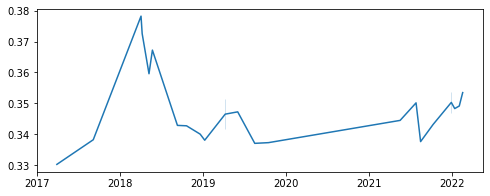

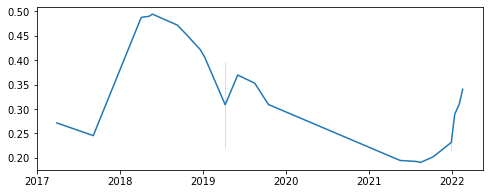

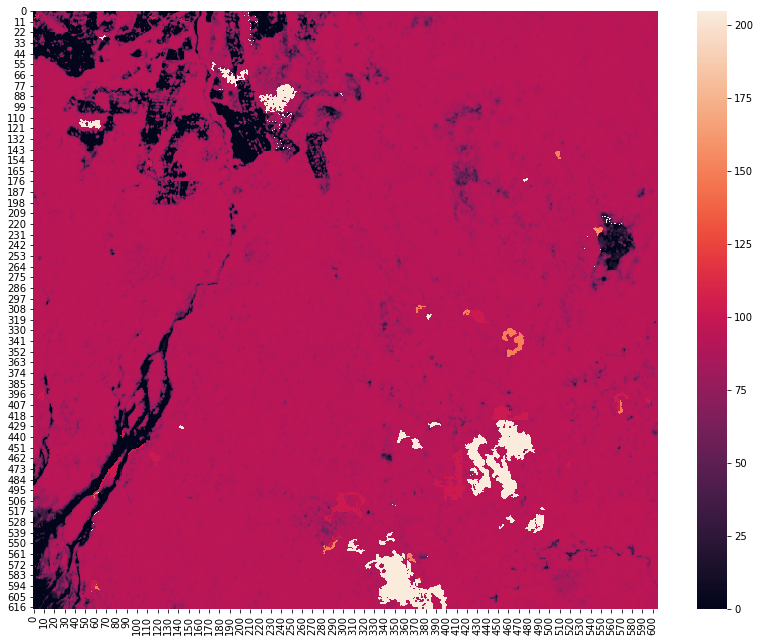

In [138]:
import itertools
year = 2018
local_path = '../../project-monitoring/tiles/'

#data = data[::-1]
for x, y in zip(xs, ys):
#for i, val in data.iterrows():
    #x = val.X_tile
    #y = val.Y_tile
    suffix = 'CHANGENEW_bigall4-may'
    fname = f"change/costarica/{str(x)}X{str(y)}Y{suffix}.tif"
    if not os.path.exists(fname):
        print(fname, " exists")
    else:
        try:
            print(f"STARTING {x}, {y}")
            #if np.logical_and(x > 2214, x < 2220):
                #if np.logical_and(y > 915, y < 920):
            fs, changemap, stable, notree = load_ttc_tiles(x, y)
            download_and_unzip_data(x, y, local_path, AWSKEY, AWSSECRET)
            bbx = tile_bbx(x, y, data)
            a17, a18, a19, a20, a21, a22, d17, d18, d19, d20, d21, d22 = load_all_ard(x, y, local_path)

            ard_path = f'{local_path}/{str(year)}/{str(x)}/{str(y)}/'
            dem = f'{ard_path}/dem_{str(x)}X{str(y)}Y.hkl'
            dem = hkl.load(dem)
            dem = median_filter(dem, size = 9)
            dem = resize(dem, (a18.shape[1:]), 0)

            fs, changemap, stable, notree = load_ttc_tiles(x, y)
            n_per_year = [a17.shape[0], a18.shape[0], a19.shape[0],
                         a20.shape[0], a21.shape[0], a22.shape[0]]
            print(n_per_year)
            ard = np.concatenate([a17, a18, a19,a20, a21, a22], axis = 0)

            dates = np.concatenate([d17, d18, d19, d20, d21, d22])

            kde, kde10, kde_expected, kde50, percentiles = make_all_kde(ard, stable)
            gain = np.zeros((5, ard.shape[1], ard.shape[2]))
            loss = np.zeros((5, ard.shape[1], ard.shape[2]))

            for i in range(5):
                print(2017 + i + 1, i)
                gain[i] = identify_gain_in_year(kde, kde10, kde_expected, dates, 2017 + i + 1) * (i + 2)
                loss[i] = identify_loss_in_year(kde, kde10, kde_expected, dates, 2017 + i + 1) * (i + 2)

            gain2, loss2 = adjust_loss_gain(gain, loss, fs, kde, kde10, kde_expected, dates)

            rotational = np.logical_and(gain2 > 0, loss2 > 0)
            med = np.median(fs, axis = 0)
            med[gain2> 0] = (gain2[gain2 > 0] + 100)
            med[loss2 > 0] = (loss2[loss2 > 0] + 200)
            med[np.logical_and(rotational, gain2 > loss2)] = 150.
            med[np.logical_and(rotational, loss2 > gain2)] = 160.

            movingavg = np.copy(percentiles).reshape((percentiles.shape[0], percentiles.shape[1] * percentiles.shape[2]))
            movingavg = np.apply_along_axis(moving_average, 0, movingavg, 9)
            movingavg = np.reshape(movingavg, (percentiles.shape[0]-8,percentiles.shape[1], percentiles.shape[2]))

            # Because our minimum mapping unit is 10 px
            for i in range(movingavg.shape[0]):
                movingavg[i] = median_filter(movingavg[i], 5)

            cfs_flat = calc_reference_change(movingavg, 0, 50, notree, dem)
            cfs_hill = calc_reference_change(movingavg, 10, 50, notree, dem)
            cfs_steep = calc_reference_change(movingavg, 20, 50, notree, dem)
            cfs_trees = calc_tree_change(movingavg, 5, stable, dem)
            cfs_trees10 = calc_tree_change(movingavg, 10, stable, dem)

            gainpx, Zlabeled, additional_gain = filter_gain_px(gain2, loss2, percentiles, cfs_flat, cfs_hill, cfs_steep,
                                    cfs_trees, cfs_trees10, notree, dem, dates)

            gain2[~np.isin(Zlabeled, gainpx)] = 0.
            gain2 = np.maximum(gain2, additional_gain)
            plt.figure(figsize=(14,11))
            rotational = np.logical_and(gain2 > 0, loss2 > 0)
            med = np.median(fs, axis = 0)
            med[gain2 > 0] = (gain2[gain2 > 0] + 100)
            med[loss2 > 0] = (loss2[loss2 > 0] + 200)
            med[np.logical_and(rotational, gain2 > loss2)] = 150.
            med[np.logical_and(rotational, loss2 > gain2)] = 160.
            for i in range(2017, 2022):
                unstable_loss = remove_unstable_loss(i, med, fs)
                med[unstable_loss] = np.median(fs, axis = 0)[unstable_loss]
            sns.heatmap(med)

            write_tif(med, bbx, x, y, 'change/costarica/', suffix = suffix)

        except Exception as e:
            print(f"Ran into {str(e)} error")

(618, 606)


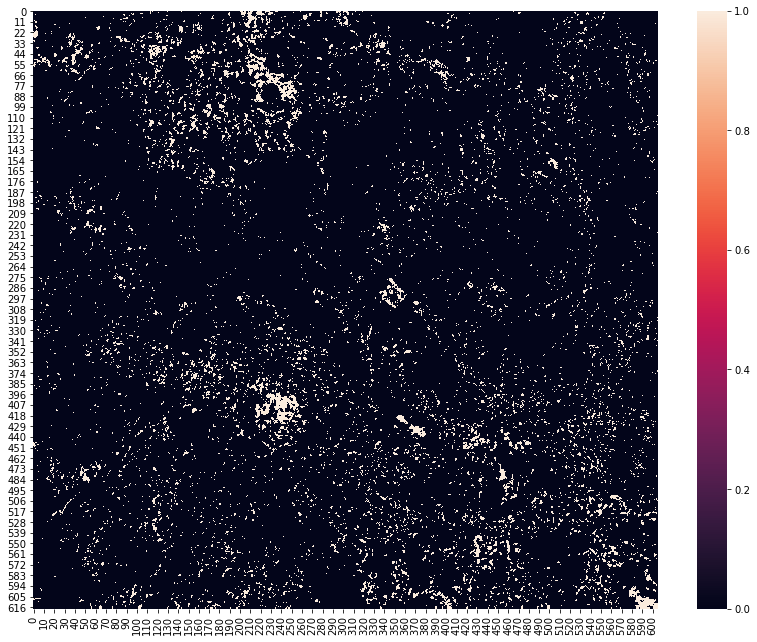

In [201]:
def identify_unstable_last_year(year, n_per_year, ard, med):
    start = np.concatenate([np.array([0]), np.cumsum(n_per_year)])
    _start = start[year - 2017]
    _end = start[year - 2016]
    # Intra-annual shift
    delta_within_year = np.min(abs(np.diff(ard[_start:_end], axis = 0)), axis = 0)
    delta_before_loss = np.min(abs(np.diff(ard[:_start-2], axis = 0)), axis = 0)
    delta = np.minimum(delta_within_year, delta_before_loss)
    delta = np.std(np.diff(ard, axis =0), axis = 0)
    #delta = 10000
    if _start > 0:
        # inter-annual shift
        delta_before = ard[_start] - ard[_start + 2]
    return delta_before / delta
l = identify_unstable_last_year(2022, n_per_year, ard, med)
print(l.shape)
plt.figure(figsize=(14,11))
sns.heatmap(l < -2)

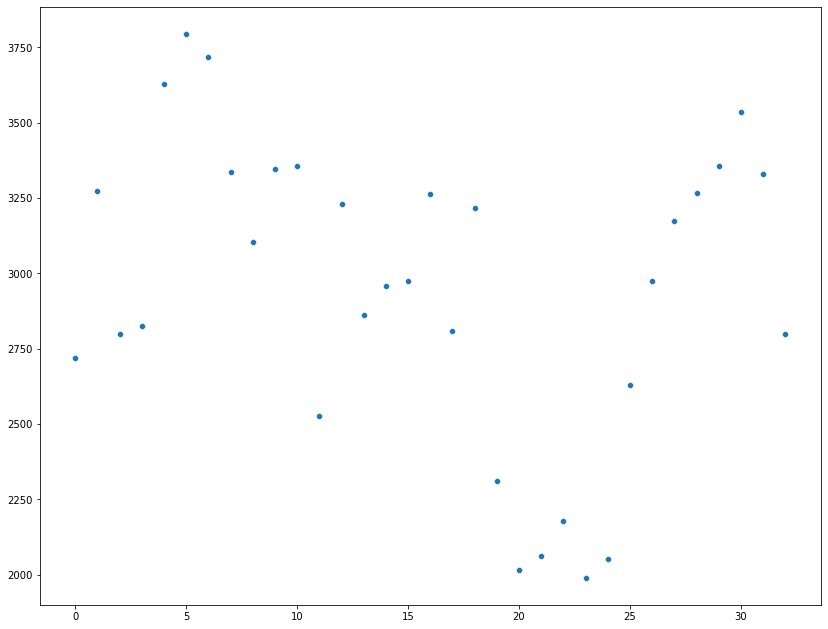

In [105]:
plt.figure(figsize=(14,11))
mins = ard[:, 400:420, 425:440]
sns.scatterplot(y = np.mean(mins, axis = (1, 2)), x = [x for x in np.arange(ard.shape[0])])
#sns.heatmap(mins, vmax = np.percentile(mins, 99), vmin = np.percentile(mins, 1))

This is the per-image NDMI across the entire image (in blue)
and the per-image NDMI for stable trees (in green)

/Users/jbrandt.terminal/opt/anaconda3/envs/tf/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/jbrandt.terminal/opt/anaconda3/envs/tf/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/jbrandt.terminal/opt/anaconda3/envs/tf/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit ke

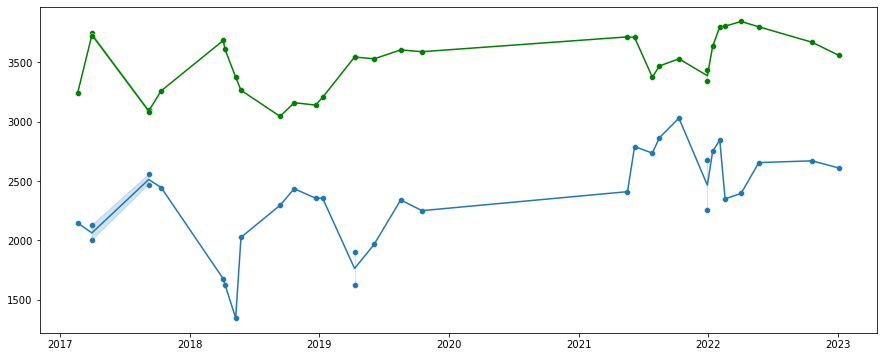

In [25]:
VERBOSE = True
if VERBOSE:
    plt.figure(figsize=(15,6))
    sns.scatterplot((dates / 365) + 2017, np.median(ard[:, notree], axis = (1)), )
    sns.lineplot((dates / 365) + 2017, np.median(ard[:, notree], axis = (1)), )
    sns.scatterplot((dates / 365) + 2017, np.median(ard[:, stable], axis = (1)), color = 'green')
    sns.lineplot((dates / 365) + 2017, np.median(ard[:, stable], axis = (1)), color = 'green')
    
if changemap is not None:
    gain = changemap == 250
    mean_gain = np.mean(ard[:, gain], axis = (1))
    mean_loss = np.mean(ard[:, changemap == 150], axis = (1))
    mean_nochange_tree = np.mean(ard[:, np.logical_and(changemap <= 100, changemap > 20)], axis = (1))
    mean_notree = np.mean(ard[:, changemap <= 20], axis = (1))

    plt.figure(figsize=(15,7))
    g = sns.scatterplot((dates / 365) + 2017, mean_gain, color = 'purple')
    g = sns.lineplot((dates / 365) + 2017, mean_gain, color = 'purple', label = 'Gain')
    g = sns.scatterplot((dates / 365) + 2017, mean_loss, color = 'red')
    g = sns.lineplot((dates / 365) + 2017, mean_loss, color = 'red', label = 'Loss')
    g = sns.scatterplot((dates / 365) + 2017, mean_nochange_tree, color = 'green')
    g = sns.lineplot((dates / 365) + 2017, mean_nochange_tree, color = 'green', label = 'Stable')
    g.set(ylabel = 'Normalized difference moisture index')

/Users/jbrandt.terminal/opt/anaconda3/envs/tf/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/jbrandt.terminal/opt/anaconda3/envs/tf/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


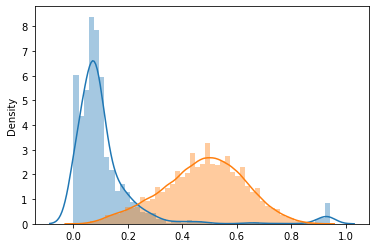

In [26]:
if VERBOSE:
    mins = np.percentile(movingavg[:, stable], 50, axis = 0)
    maxs = np.percentile(movingavg[:, notree], 50, axis = 0)
    sns.distplot(maxs)
    sns.distplot(mins)


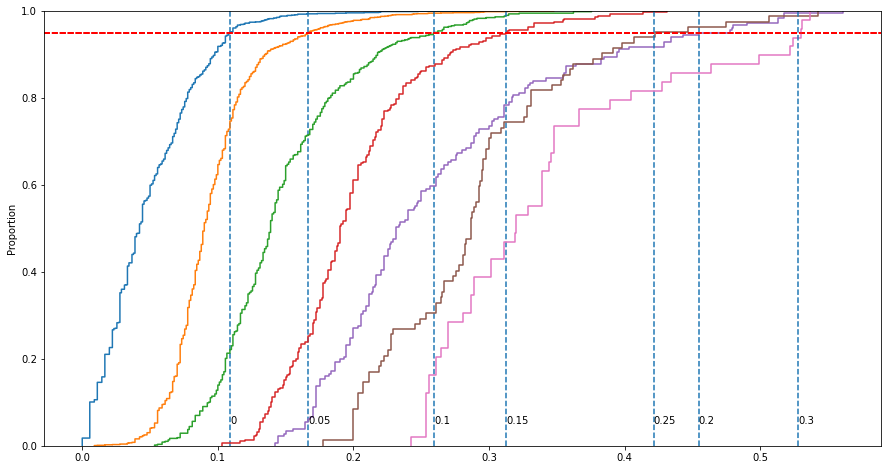

In [27]:
if VERBOSE:
    plt.figure(figsize=(15,8))
    for i in [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]:
        baseline = i

        counterfactual = np.mean(movingavg[:6], axis = 0)
        counterfactual = np.logical_and(notree, np.logical_and(counterfactual >= baseline,
                                                               counterfactual < baseline + 0.05))
        counterfactual = np.percentile(movingavg[6:-10, counterfactual], 95, axis = 0)

        g = sns.ecdfplot(counterfactual.flatten())#, kind = 'kde')
        g.axhline(0.95, ls='--', color = 'red')
        endline =  np.percentile(counterfactual, 95)
        g.axvline(endline, ls='--')
        g.text(endline, 0.05, i)
        #endline = np.around(endline, 3)
        #g.set_title(f"Baseline: {baseline}, endline: {endline}")

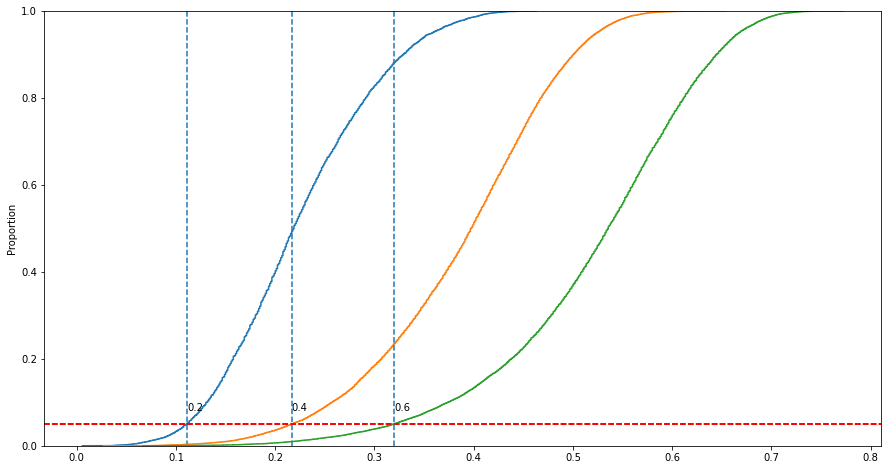

In [28]:
if VERBOSE:
    plt.figure(figsize=(15,8))
    for i in [0.2, 0.4,0.6]:
        baseline = i

        counterfactual = np.mean(movingavg[:6], axis = 0)
        counterfactual = np.logical_and(stable, np.logical_and(counterfactual >= baseline,
                                                               counterfactual < baseline + 0.05))
        counterfactual = np.percentile(movingavg[6:-10, counterfactual], 5, axis = 0)
        #counterfactual.shape
        #sns.heatmap(counterfactual)

        g = sns.ecdfplot(counterfactual.flatten())#, kind = 'kde')
        g.axhline(0.05, ls='--', color = 'red')
        endline =  np.percentile(counterfactual, 5)
        g.axvline(endline, ls='--')
        g.text(endline, 0.08, i)
        #endline = np.around(endline, 3)
        #g.set_title(f"Baseline: {baseline}, endline: {endline}")

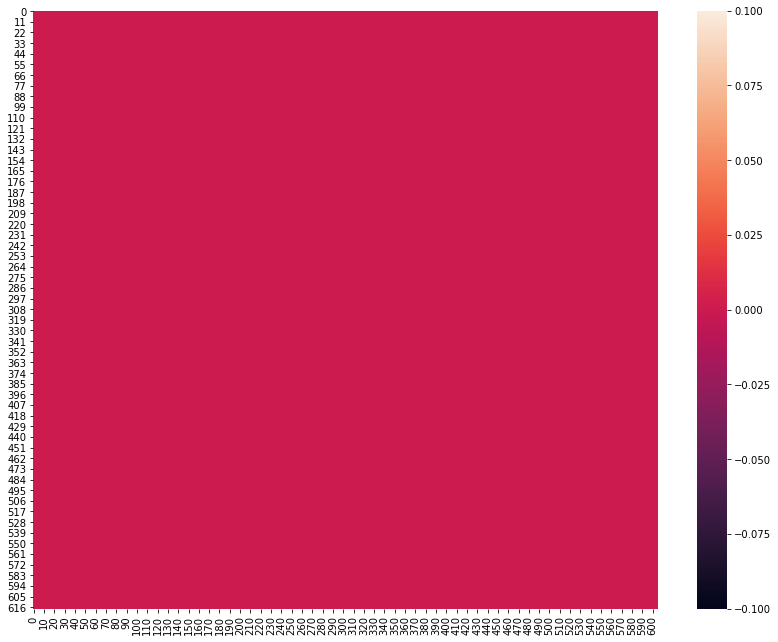

In [29]:
if VERBOSE:
    plt.figure(figsize=(14,11))
    sns.heatmap((gain2  * ~np.isin(Zlabeled, gainpx)) - additional_gain)

/Users/jbrandt.terminal/opt/anaconda3/envs/tf/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/jbrandt.terminal/opt/anaconda3/envs/tf/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/jbrandt.terminal/opt/anaconda3/envs/tf/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit ke

<Figure size 1080x576 with 0 Axes>

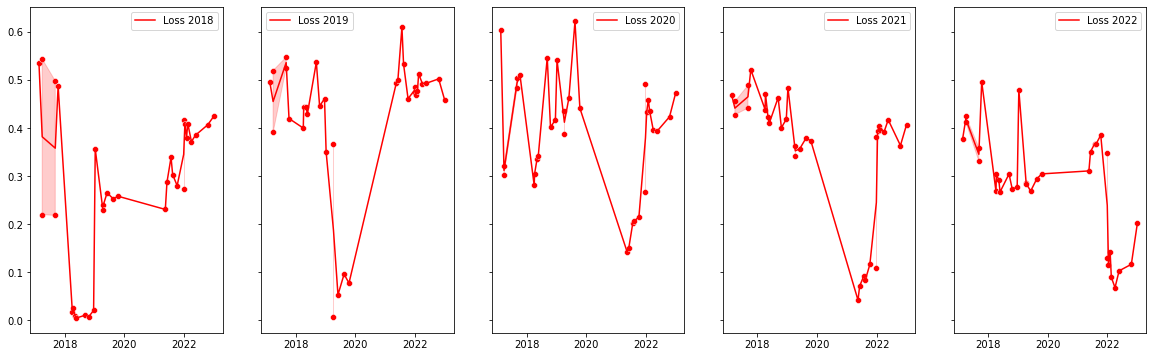

In [30]:
if VERBOSE:
    mean_loss18 = np.mean(percentiles[:, loss2 == 1], axis = (1))
    mean_loss19 = np.mean(percentiles[:, loss2 == 2], axis = (1))
    mean_loss20 = np.mean(percentiles[:, loss2 == 3], axis = (1))
    mean_loss21 = np.mean(percentiles[:, loss2 == 4], axis = (1))
    mean_loss22 = np.mean(percentiles[:, loss2 == 5], axis = (1))
    #mean_nochange_tree = np.mean(percentiles[:, np.logical_and(changemap <= 100, changemap > 40)], axis = (1))


    plt.figure(figsize=(15,8))
    fig, axs = plt.subplots(ncols=5, figsize = (20, 6), sharey = True)
    sns.scatterplot((dates / 365) + 2017, mean_loss18, color = 'red', ax = axs[0])
    sns.lineplot((dates / 365) + 2017, mean_loss18, color = 'red', label = 'Loss 2018', ax = axs[0])
    sns.scatterplot((dates / 365) + 2017, mean_loss19, color = 'red', ax = axs[1])
    sns.lineplot((dates / 365) + 2017, mean_loss19, color = 'red', label = 'Loss 2019', ax = axs[1])
    sns.scatterplot((dates / 365) + 2017, mean_loss20, color = 'red', ax = axs[2])
    sns.lineplot((dates / 365) + 2017, mean_loss20, color = 'red', label = 'Loss 2020', ax = axs[2])
    sns.scatterplot((dates / 365) + 2017, mean_loss21, color = 'red', ax = axs[3])
    sns.lineplot((dates / 365) + 2017, mean_loss21, color = 'red', label = 'Loss 2021', ax = axs[3])
    sns.scatterplot((dates / 365) + 2017, mean_loss22, color = 'red', ax = axs[4])
    sns.lineplot((dates / 365) + 2017, mean_loss22, color = 'red', label = 'Loss 2022', ax = axs[4])
    #g = sns.lineplot((dates / 365) + 2017, mean_nochange_tree, color = 'green', label = 'Stable', ax = axs[0])
    #g = sns.lineplot((dates / 365) + 2017, mean_nochange_tree, color = 'green', label = 'Stable', ax = axs[1])
    #g = sns.lineplot((dates / 365) + 2017, mean_nochange_tree, color = 'green', label = 'Stable', ax = axs[2])
    #g = sns.lineplot((dates / 365) + 2017, mean_nochange_tree, color = 'green', label = 'Stable', ax = axs[3])
    #g = sns.lineplot((dates / 365) + 2017, mean_nochange_tree, color = 'green', label = 'Stable', ax = axs[4])

    #g.set(ylim=(0, 1))
    g.set(ylabel = 'Anomaly probility')

/Users/jbrandt.terminal/opt/anaconda3/envs/tf/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/jbrandt.terminal/opt/anaconda3/envs/tf/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/jbrandt.terminal/opt/anaconda3/envs/tf/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit ke

<Figure size 1080x576 with 0 Axes>

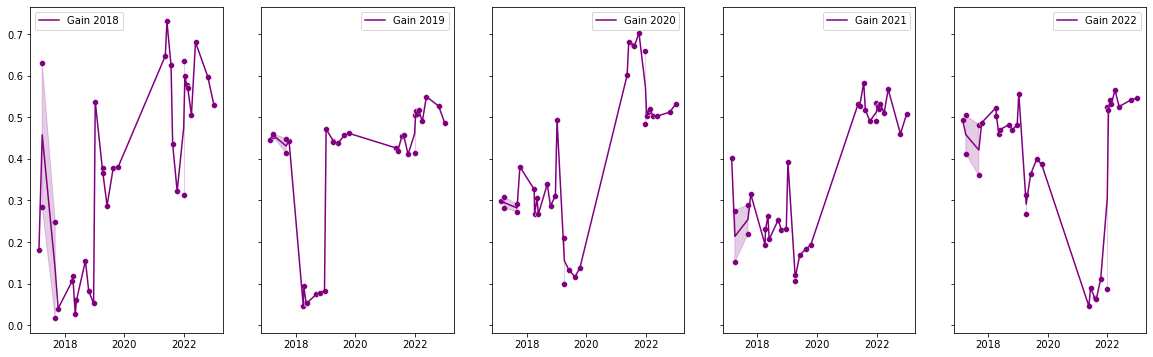

In [31]:
if VERBOSE:
    mean_loss18 = np.mean(percentiles[:, gain2 == 1], axis = (1))
    mean_loss19 = np.mean(percentiles[:, gain2 == 2], axis = (1))
    mean_loss20 = np.mean(percentiles[:, gain2 == 3], axis = (1))
    #mean_loss20 = percentiles[:, gain2 == 3][:, 25]
    mean_loss21 = np.mean(percentiles[:, gain2 == 4], axis = (1))
    mean_loss22 = np.mean(percentiles[:, gain2 == 5], axis = (1))
    #mean_nochange_tree = np.mean(percentiles[:, np.logical_and(changemap <= 100, changemap > 40)], axis = (1))


    plt.figure(figsize=(15,8))
    fig, axs = plt.subplots(ncols=5, figsize = (20, 6), sharey = True)
    #sns.scatterplot((dates / 365) + 2017, 1 - mean_loss, color = 'red')
    #sns.lineplot((dates / 365) + 2017, 1 - mean_loss, color = 'red', label = 'Loss')
    sns.scatterplot((dates / 365) + 2017, mean_loss18, color = 'purple', ax = axs[0])
    sns.lineplot((dates / 365) + 2017, mean_loss18, color = 'purple', label = 'Gain 2018', ax = axs[0])
    sns.scatterplot((dates / 365) + 2017, mean_loss19, color = 'purple', ax = axs[1])
    sns.lineplot((dates / 365) + 2017, mean_loss19, color = 'purple', label = 'Gain 2019', ax = axs[1])
    sns.scatterplot((dates / 365) + 2017, mean_loss20, color = 'purple', ax = axs[2])
    sns.lineplot((dates / 365) + 2017, mean_loss20, color = 'purple', label = 'Gain 2020', ax = axs[2])
    sns.scatterplot((dates / 365) + 2017, mean_loss21, color = 'purple', ax = axs[3])
    sns.lineplot((dates / 365) + 2017, mean_loss21, color = 'purple', label = 'Gain 2021', ax = axs[3])
    sns.scatterplot((dates / 365) + 2017, mean_loss22, color = 'purple', ax = axs[4])
    sns.lineplot((dates / 365) + 2017, mean_loss22, color = 'purple', label = 'Gain 2022', ax = axs[4])
    #g = sns.lineplot((dates / 365) + 2017, mean_nochange_tree, color = 'green', label = 'Stable', ax = axs[0])
    #g = sns.lineplot((dates / 365) + 2017, mean_nochange_tree, color = 'green', label = 'Stable', ax = axs[1])
    #g = sns.lineplot((dates / 365) + 2017, mean_nochange_tree, color = 'green', label = 'Stable', ax = axs[2])
    #g = sns.lineplot((dates / 365) + 2017, mean_nochange_tree, color = 'green', label = 'Stable', ax = axs[3])
    #g = sns.lineplot((dates / 365) + 2017, mean_nochange_tree, color = 'green', label = 'Stable', ax = axs[4])

    #g.set(ylim=(0, 1))
    g.set(ylabel = 'Anomaly probility')

In [15]:
if VERBOSE:
    mean_rot = np.mean(percentiles[:, med == 150], axis = (1))
    mean_rot2 = np.mean(percentiles[:, med == 160], axis = (1))
    #mean_nochange_tree = np.mean(percentiles[:, np.logical_and(changemap <= 100, changemap > 40)], axis = (1))

    fig, axs = plt.subplots(ncols=2, figsize = (20, 6), sharey = True)
    #sns.scatterplot((dates / 365) + 2017, 1 - mean_loss, color = 'red')
    #sns.lineplot((dates / 365) + 2017, 1 - mean_loss, color = 'red', label = 'Loss')
    sns.scatterplot((dates / 365) + 2017, mean_rot, color = 'orange', ax = axs[0])
    sns.lineplot((dates / 365) + 2017, mean_rot, color = 'orange', label = 'Rotation - loss, gain', ax = axs[0])
    sns.scatterplot((dates / 365) + 2017, mean_rot2, color = 'blue', ax = axs[1])
    sns.lineplot((dates / 365) + 2017, mean_rot2, color = 'blue', label = 'Rotation - gain, loss', ax = axs[1])
    #g = sns.lineplot((dates / 365) + 2017, mean_nochange_tree, color = 'green', label = 'Stable', ax = axs[0])
    #g = sns.lineplot((dates / 365) + 2017, mean_nochange_tree, color = 'green', label = 'Stable', ax = axs[1])

    #g.set(ylim=(0, 1))
    g.set(ylabel = 'Anomaly probility')

#### 